# Dati mancanti {#sec-missing-data} 

**Prerequisiti**

**Concetti e competenze chiave**

**Preparazione del Notebook**

In [1]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import scipy.stats as stats
from scipy.special import expit  # Funzione logistica
from cmdstanpy import cmdstan_path, CmdStanModel

# Configuration
seed = sum(map(ord, "missing_data"))
rng = np.random.default_rng(seed=seed)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Define directories
home_directory = os.path.expanduser("~")
project_directory = f"{home_directory}/_repositories/psicometria"

# Print project directory to verify
print(f"Project directory: {project_directory}")

Project directory: /Users/corradocaudek/_repositories/psicometria


## Introduzione {.unnumbered}

Nel campo della data science, la gestione dei dati mancanti rappresenta una sfida cruciale e una competenza fondamentale per gli analisti e i ricercatori. I dati mancanti non sono solo una comune occorrenza nei dataset reali, ma possono anche avere un impatto significativo sulla qualità delle analisi, sulle inferenze tratte e sulle decisioni basate su tali dati. L'importanza di affrontare correttamente i dati mancanti risiede nella necessità di mantenere l'integrità delle analisi statistiche e di evitare conclusioni errate o distorte. Una gestione appropriata dei dati mancanti permette di migliorare l'accuratezza dei modelli predittivi, di aumentare la robustezza delle analisi e di garantire che le decisioni basate sui dati siano informate e affidabili. Pertanto, comprendere le cause dei dati mancanti, conoscere le diverse tipologie di assenza dei dati, come classificato nella tassonomia di Rubin, e applicare le tecniche di trattamento più adeguate sono competenze essenziali nella data science per massimizzare il valore estratto dai dati disponibili.

## La tassonomia di Rubin

La tassonomia dei dati mancanti di Rubin introduce una classificazione che aiuta a comprendere e gestire le situazioni in cui i dati non sono completamente disponibili. Questa classificazione è particolarmente rilevante in ambiti come la statistica, la ricerca scientifica e l'analisi dei dati, dove la presenza di dati mancanti può influenzare significativamente i risultati degli studi. La tassonomia identifica tre categorie principali: Dati Mancanti Completamente a Caso (MCAR), Dati Mancanti a Caso (MAR) e Dati Mancanti Non a Caso (MNAR). Ognuna di queste categorie si basa su specifiche assunzioni relative alla probabilità condizionata che un dato sia mancante. Vediamo nel dettaglio:

1. **Dati Mancanti Completamente a Caso (MCAR)**: Questa categoria rappresenta la situazione meno problematica tra le tre. L'assunzione MCAR suggerisce che la mancanza di dati avviene in modo completamente casuale, senza alcuna relazione sia con i dati osservati che con quelli non osservati. La mancanza è attribuibile a circostanze casuali e non legate alle caratteristiche dei dati stessi. In pratica, questo significa che la probabilità che un dato sia mancante è la stessa per tutte le osservazioni. Quando i dati sono MCAR, le tecniche di analisi possono procedere senza introdurre distorsioni significative nei risultati.

2. **Dati Mancanti a Caso (MAR)**: In questa categoria, la probabilità che un dato sia mancante può dipendere dai dati osservati, ma non da quelli non osservati. Questo tipo di mancanza viene considerato "ignorabile" perché, conoscendo i dati osservati, è possibile procedere con l'analisi senza compromettere l'affidabilità delle inferenze, sebbene possa esserci una perdita di precisione. Questa situazione si verifica quando la ragione della mancanza di dati è correlata a qualche caratteristica osservabile nel dataset, permettendo di gestire la mancanza attraverso l'analisi dei dati disponibili.

3. **Dati Mancanti Non a Caso (MNAR)**: Questa è la situazione più complessa e potenzialmente problematica. I dati sono considerati MNAR quando la probabilità che un dato sia mancante dipende dalle informazioni non osservate. Ciò significa che la mancanza di dati è correlata a valori che non sono noti o osservabili, rendendo più difficile l'imputazione e l'analisi. Le tecniche standard di gestione dei dati mancanti potrebbero introdurre distorsioni significative nei risultati a causa del rischio di confondimento. La gestione dei dati MNAR richiede metodi avanzati e cautela nell'interpretazione dei risultati.

Le assunzioni su cui si basa questa tassonomia sono fondamentali per scegliere il metodo di trattamento dei dati mancanti più appropriato. Tuttavia, è importante notare che queste assunzioni sono intrinsecamente non verificabili. L'analisi e le conclusioni di uno studio dipenderanno dalla plausibilità di queste assunzioni nel contesto specifico in cui vengono applicate. La scelta di come trattare i dati mancanti dovrebbe quindi essere attentamente considerata e giustificata nel contesto della ricerca.

## Un Esempio Empirico

L'analisi e il trattamento dei dati mancanti rivestono un ruolo cruciale nell'interpretazione dei risultati di uno studio. Esaminiamo i diversi scenari di dati mancanti che hai delineato, prendendo spunto dall'esempio metaforico del "cane che mangia i compiti", presentato nel tutorial di [Dustin Stansbury](https://github.com/dustinstansbury/statistical-rethinking-2023/blob/main/Lecture%2018%20-%20Missing%20Data.ipynb).


### 1. Perdita di Dati Casuale e Indipendente dalle Cause
- **Esempio**:  Il fenomeno del "cane che mangia i compiti" avviene in maniera casuale.
- **Conseguenze**: In questa situazione, la perdita di dati è classificata come "Missing Completely At Random" (MCAR), ovvero l'assenza di dati non è in alcun modo correlata né alle variabili osservate né a quelle non osservate.
- **Gestione**: È possibile eliminare i casi con dati mancanti senza introdurre distorsioni, benché ciò possa ridurre l'efficienza dello studio a causa della diminuzione della dimensione del campione.

In [2]:
# Helper function to plot regression line
def plot_regression_line(x, y, color, label, **plot_kwargs):
    valid_idx = ~np.isnan(y)
    
    X = np.vstack((np.ones_like(x[valid_idx]), x[valid_idx])).T
    intercept, slope = np.linalg.lstsq(X, y[valid_idx], rcond=None)[0]
    
    xs = np.linspace(x.min(), x.max(), 10)
    ys = xs * slope + intercept
    plt.plot(xs, ys, color=color, label=label, **plot_kwargs)

# Function to plot dog homework data
def plot_dog_homework(S, H, Hstar, title=None):
    
    # Plot S vs H
    plt.scatter(S, H, color='k', alpha=1, label='total', s=10)
    plot_regression_line(S, H, label='total trend', color='k', alpha=.5)
    
    # Plot S vs Hstar
    plt.scatter(S, Hstar, color='C0', alpha=.8, label='incomplete')
    plot_regression_line(S, Hstar, label='incomplete trend', color='C0', alpha=.5)
    
    # Set labels and title
    plt.xlabel("S")
    plt.ylabel("H")
    if title is not None:
        plt.title(title)
    plt.legend()

    plt.show()  # Display the plot

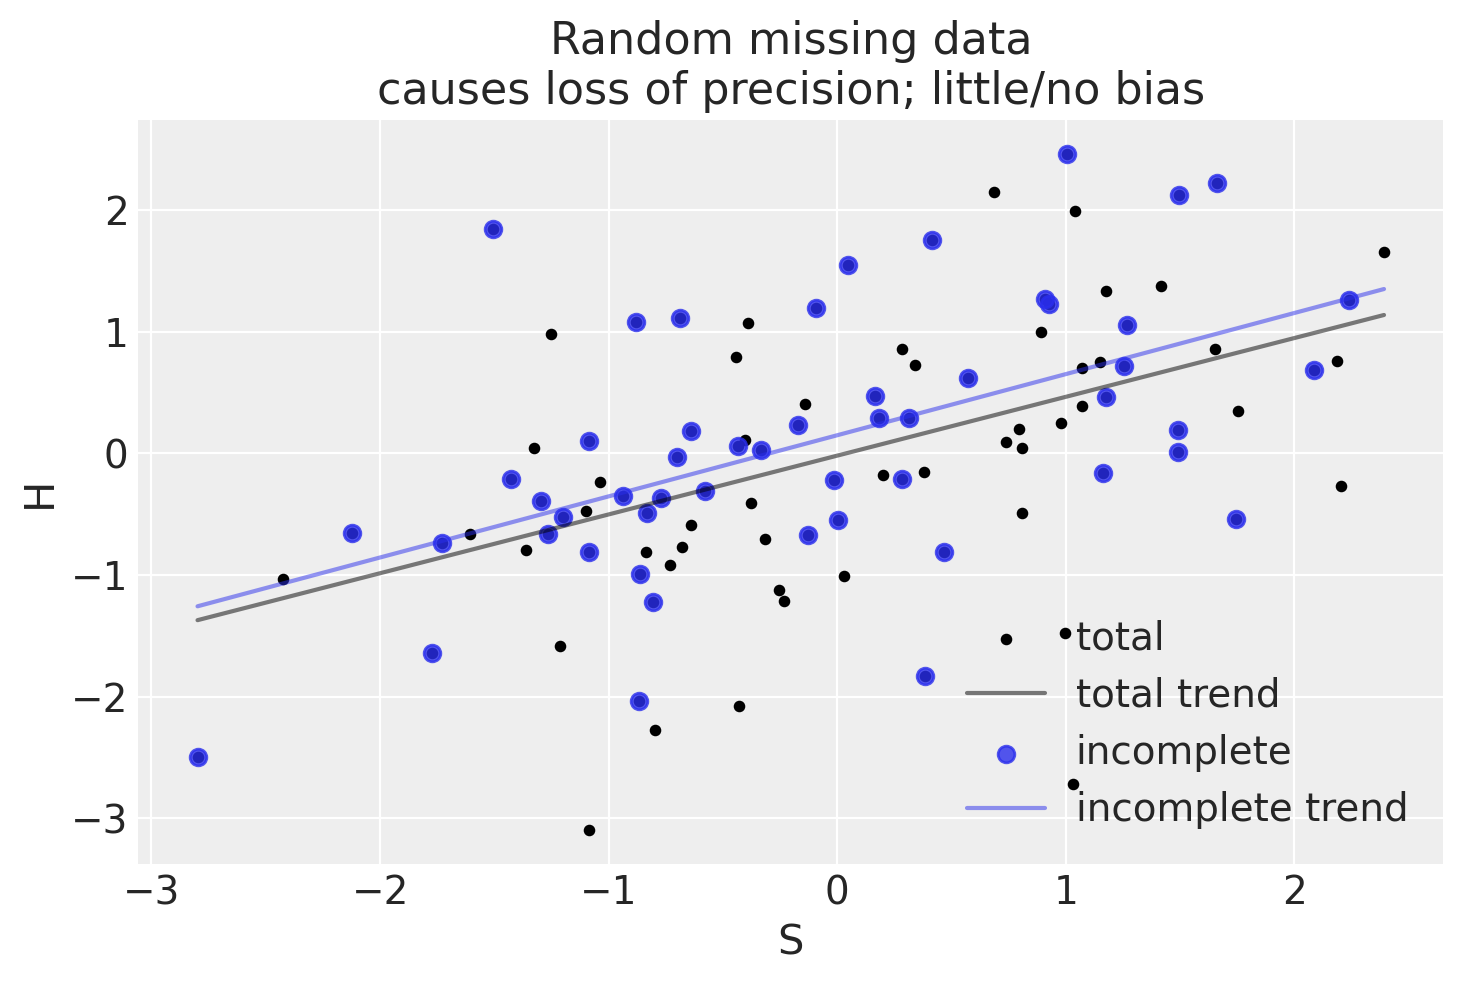

In [3]:
np.random.seed(123)
n_homework = 100
# Student knowledge
S = stats.norm.rvs(size=n_homework)

# Homework score
mu_score = S * 0.5
H = stats.norm.rvs(mu_score)

# Dog eats 50% of of homework _at random_
D = stats.bernoulli(0.5).rvs(size=n_homework)
Hstar = H.copy()
Hstar[D==1] = np.nan

plot_dog_homework(S, H, Hstar, title="Random missing data\ncauses loss of precision; little/no bias")

In scenari di dati mancanti completamente a caso, si verifica una perdita di precisione, ma, mediamente, l'analisi non risulta distorta.

### 2. Perdita di Dati Condizionata dalle Cause
- **Esempio**: Il cane mangia i compiti in base alle abitudini di studio dello studente, ad esempio se lo studente trascura di nutrire il cane dopo aver studiato intensamente.
- **Conseguenze**: Questo caso è definito come "Missing At Random" (MAR), in cui la probabilità di perdita di dati è correlata a variabili osservabili.
- **Gestione**: È necessario adeguare l'analisi in base alla causa per prevenire distorsioni. L'impiego di modelli statistici che considerano le variabili legate alla mancanza di dati può risultare efficace.

In una prima simulazione,  il trattamento (competenza dello studente) e l'effetto (qualità del compito) hanno una relazione lineare. Questo scenario è molto raro.

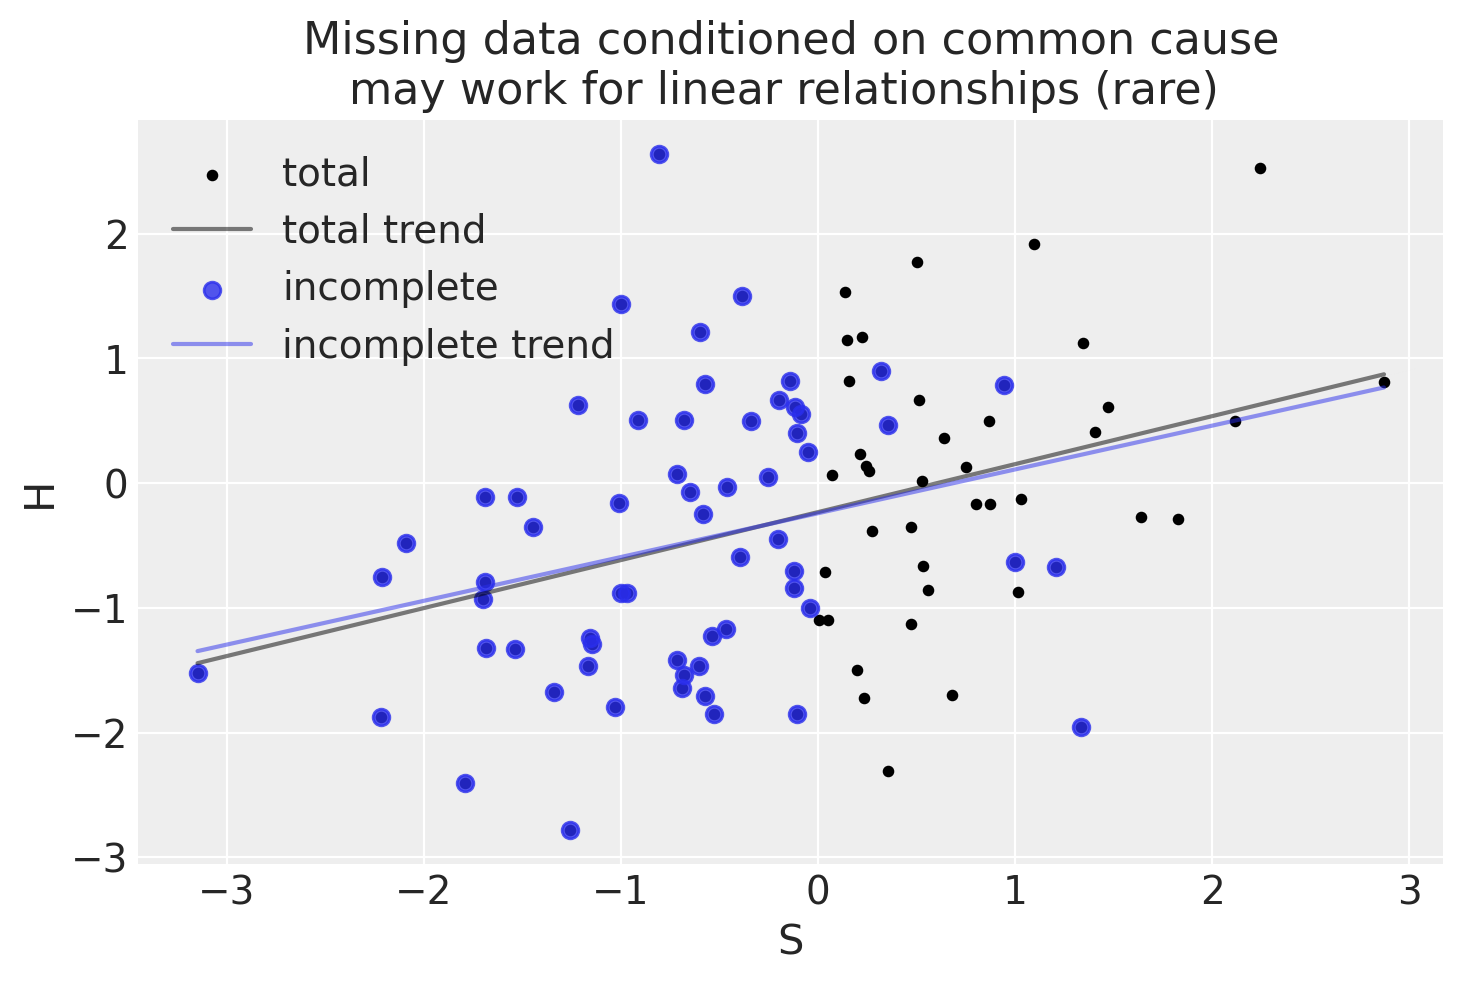

In [4]:
np.random.seed(12)
n_homework = 100
# Student knowledge
S = stats.norm.rvs(size=n_homework)

# Linear association between student ability and homework score
mu_score = S * 0.5
H = stats.norm.rvs(mu_score)

# Dog eats based on the student's ability
p_dog_eats_homework = np.where(S > 0, 0.9, 0)
D = stats.bernoulli.rvs(p=p_dog_eats_homework)
Hstar = H.copy()
Hstar[D==1] = np.nan

plot_dog_homework(S, H, Hstar, title="Missing data conditioned on common cause\nmay work for linear relationships (rare) ")

Quando l'associazione tra abilità degli studenti e punteggio dei compiti è lineare, l'adattamento dal campione completo e da quello incompleto può risultare simile, con una perdita di precisione solo agli estremi del campione.

Consideriamo ora il caso in cui il trattamento (capacità dello studente) e l'effetto (caratteristiche del compito) non sono associati linearmente. Questo scenario è molto più comune.

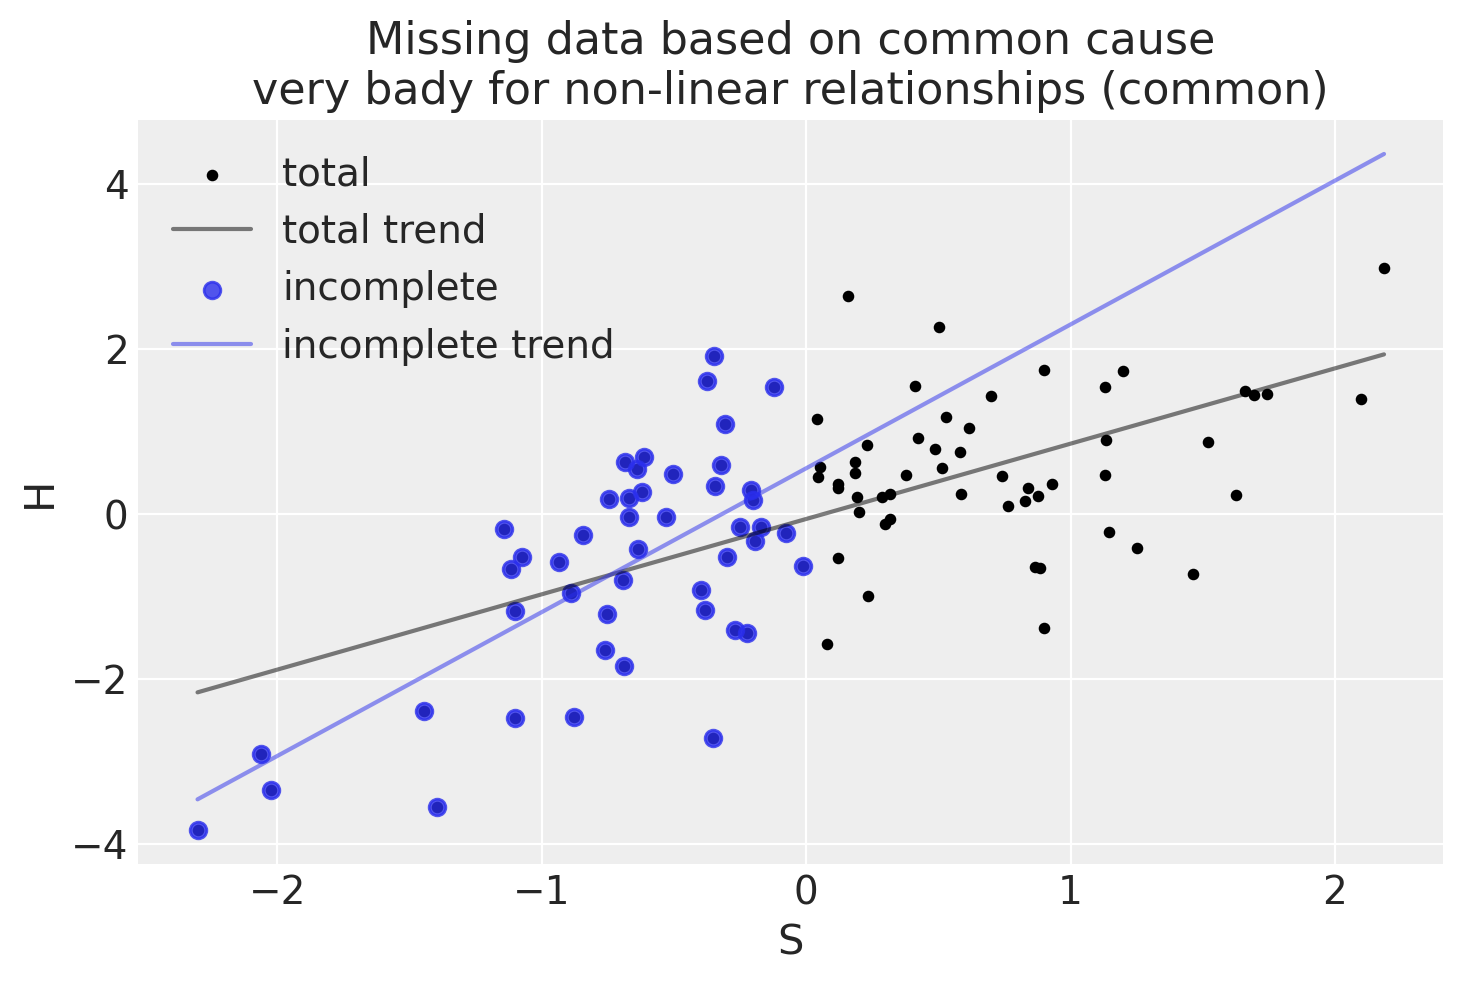

In [5]:
np.random.seed(1)
n_homework = 100
# Student knowledge
S = stats.norm.rvs(size=n_homework)

# Nonlinear association between student ability and homework score
mu_score = 1 - np.exp(-0.7 * S)
H = stats.norm.rvs(mu_score)

# Dog eats all the homework of above-average students
p_dog_eats_homework = np.where(S > 0, 1, 0)
D = stats.bernoulli.rvs(p=p_dog_eats_homework)
Hstar = H.copy()
Hstar[D==1] = np.nan

plot_dog_homework(S, H, Hstar, title="Missing data based on common cause\nvery bady for non-linear relationships (common)")

In un tale scenario, l'adattamento dal campione completo e da quello incompleto sono molto diversi. In altre parole, l'analisi del campione incompleto produce un risultato distorto.

### 3. Perdita di Dati Condizionata dal Risultato
- **Esempio**: Il cane mangia i compiti in base al punteggio ottenuto.
- **Conseguenze**:  Questo scenario è classificato come "Missing Not At Random" (MNAR), in cui la perdita di dati è direttamente correlata al risultato mancante, complicando significativamente la gestione.
- **Gestione**: Spesso, affrontare questa situazione richiede di modellare il processo causale alla base della perdita di dati, utilizzando tecniche come l'analisi di sopravvivenza o l'impiego di dati censurati.

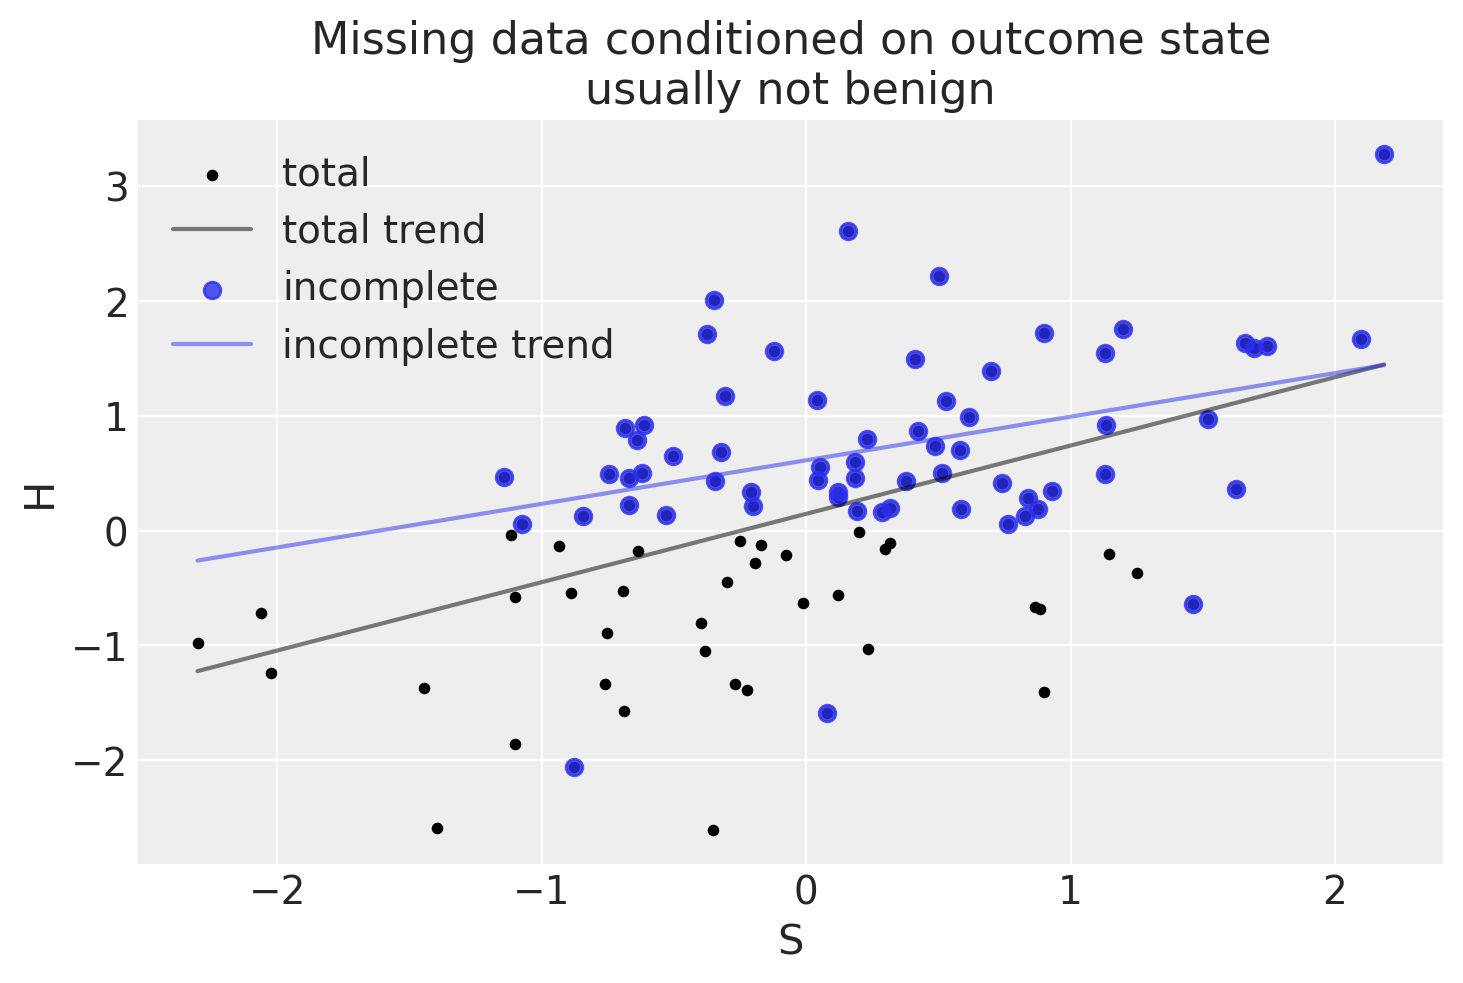

In [6]:
np.random.seed(1)
n_homework = 100
# Student knowledge
S = stats.norm.rvs(size=n_homework)

# Linear association between ability and score
mu_score = S * 0.5
H = stats.norm.rvs(mu_score)

# Dog eats 90% of homework that is below average
p_dog_eats_homework = np.where(H < 0, 0.9, 0)
D = stats.bernoulli.rvs(p=p_dog_eats_homework)
Hstar = H.copy()
Hstar[D==1] = np.nan

plot_dog_homework(S, H, Hstar, title="Missing data conditioned on outcome state\nusually not benign")


l'adattamento dal campione completo e da quello incompleto sono molto diversi. In altre parole, l'analisi del campione incompleto produce un risultato distorto. La situazione è simile a quella precedene in cui la relazione tra cause e risultati non era lineare.

Senza conoscere la relazione causale tra il risultato e la perdita di dati, e le forme funzionali di come X è associato con Y, è difficile tenere conto di questo scenario.

## Commenti e considerazioni conclusive

In conclusione, la strategia di gestione dei dati mancanti varia a seconda della loro relazione con le variabili nel modello causale. Comprendere la natura della perdita di dati è vitale per scegliere l'approccio analitico corretto e per interpretare con precisione i risultati dello studio. Solo nel caso di dati mancanti completamente a caso, l'analisi che ignora la mancanza di dati produce risultati affidabili.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Thu Jun 13 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

matplotlib : 3.8.4
pandas     : 2.2.2
statsmodels: 0.14.2
arviz      : 0.18.0
numpy      : 1.26.4
seaborn    : 0.13.2
xarray     : 2024.5.0
scipy      : 1.13.1

Watermark: 2.4.3

